In [164]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [165]:
def get_ids():
    target_ids = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
    target_ids['Season'] = target_ids.index.map(lambda i: i[:4])
    target_ids['team_a'] = target_ids.index.map(lambda i: i[5:9])
    target_ids['team_b'] = target_ids.index.map(lambda i: i[10:14])
    target_ids['in_target'] = True
    ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
    train_ids = pd.DataFrame(ncaa_games.Season.map(str) + '_'
                            + ncaa_games.WTeamID.map(str) + '_'
                            + ncaa_games.LTeamID.map(str))\
        .rename(columns={0: 'ID'}).set_index('ID')
    train_ids['Season'] = train_ids.index.map(lambda i: i[:4])
    train_ids['team_a'] = train_ids.index.map(lambda i: i[5:9])
    train_ids['team_b'] = train_ids.index.map(lambda i: i[10:14])
    return train_ids, target_ids

train, target = get_ids()
train.sample()

,Season,team_a,team_b
ID,,,
2006_1206_1455,2006,1206,1455


In [510]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
1554,2009,138,1181,74,1400,69,N,0,5


In [496]:
ncaa_games.groupby(['Season', 'WTeamID', 'LTeamID']).count().head()

DayNum  WScore  LScore  WLoc  NumOT  diff
Season WTeamID LTeamID                                           
1985   1104    1112          1       1       1     1      1     1
               1433          1       1       1     1      1     1
       1116    1234          1       1       1     1      1     1
       1120    1242          1       1       1     1      1     1
               1345          1       1       1     1      1     1

In [508]:
data.head()

,Season,a_win,in_target,team_a,team_b
0,1985,True,False,1116,1234
1,1985,True,False,1120,1345
2,1985,True,False,1207,1250
3,1985,True,False,1229,1425
4,1985,True,False,1242,1325


In [550]:
data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 5
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    # AVERAGE DIFF TO OPPONENT IN THE SEASON
    season_wins_against_opponent = ncaa_games.groupby(['Season', 'WTeamID', 'LTeamID']).mean()[['diff']]\
        .reset_index().rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)})
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_on=['Season', 'WTeamID', 'LTeamID'],
                    how='left')\
        .drop(['WTeamID', 'LTeamID'], axis=1)
    for l in range(1, lags+1):
        data['season_wins_against_opponent_{}_lag-{}'.format(team, l)] = data\
            ['season_wins_against_opponent_{}'.format(team)].shift(l).fillna(0)
        
    data.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    
    # NUMBER OF TIMES THE OPPONENT HAS BEEN BEATEN
    season_diff_agains_opponent = ncaa_games.groupby(['Season', 'WTeamID', 'LTeamID']).count()[['diff']]\
        .reset_index().rename(columns={'diff': 'season_diff_agains_opponent_{}'.format(team)})
    data = pd.merge(data, season_diff_agains_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_on=['Season', 'WTeamID', 'LTeamID'],
                    how='left')\
        .drop(['WTeamID', 'LTeamID'], axis=1)
    for l in range(1, lags+1):
        data['season_diff_agains_opponent_{}_lag-{}'.format(team, l)] = data\
            ['season_diff_agains_opponent_{}'.format(team)].shift(l).fillna(0)
        
    data.drop('season_diff_agains_opponent_{}'.format(team), inplace=True, axis=1)
    
    # AVERAGE DIFF ON WON GAMES
#     average_win_diff = ncaa_games.groupby(['Season', 'WTeamID'])[['diff']].mean()\
#         .reset_index().rename(columns={'diff': 'average_win_diff_{}'.format(team)})
#     data = pd.merge(data, average_win_diff,
#                     left_on=['Season', 'team_{}'.format(team)], right_on=['Season', 'WTeamID'],
#                     how='left')\
#         .drop('WTeamID', axis=1)
#     for l in range(1, lags+1):
#         data['average_win_diff_{}_lag-{}'.format(team, l)] = data['average_win_diff_{}'.format(team)].shift(l)
        
#     data.drop('average_win_diff_{}'.format(team), inplace=True, axis=1)
        
    # GAMES WON IN SEASON TOURNAMENT
    won_in_season = ncaa_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .reset_index().rename(columns={'diff': 'won_in_season_{}'.format(team)})
    data = pd.merge(data, won_in_season,
                    left_on=['Season', 'team_{}'.format(team)], right_on=['Season', 'WTeamID'],
                    how='left')\
        .drop('WTeamID', axis=1).fillna(0)
    for l in range(1, lags+1):
        data['won_in_season_{}_lag-{}'.format(team, l)] = data['won_in_season_{}'.format(team)].shift(l)
        
    data.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    
        
data = data.dropna()
data.tail(5)

,Season,a_win,in_target,team_a,team_b,season_wins_against_opponent_a_lag-1,season_wins_against_opponent_a_lag-2,season_wins_against_opponent_a_lag-3,season_wins_against_opponent_a_lag-4,season_wins_against_opponent_a_lag-5,...,season_diff_agains_opponent_b_lag-1,season_diff_agains_opponent_b_lag-2,season_diff_agains_opponent_b_lag-3,season_diff_agains_opponent_b_lag-4,season_diff_agains_opponent_b_lag-5,won_in_season_b_lag-1,won_in_season_b_lag-2,won_in_season_b_lag-3,won_in_season_b_lag-4,won_in_season_b_lag-5
11224,2017,False,True,1455,1458,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0
11225,2017,False,True,1455,1462,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,2.0,0.0
11226,2017,False,True,1457,1458,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3.0,2.0
11227,2017,False,True,1457,1462,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,3.0,2.0,0.0,3.0
11228,2017,False,True,1458,1462,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,2.0,3.0,2.0,0.0


In [551]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data[~data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y = data[~data.in_target.astype(bool)][['a_win']]

kf = KFold(n_splits=8, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.6811519748333729
0.6719764428721233
0.6770812871047494
0.6728573271609617
0.6806788070861137
0.6842578528166721
0.6971840294021548
0.7153321109204129
Metric Mean: 0.69 (0.01)


In [552]:
X_sub = data[data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

xgb = XGBClassifier()
xgb.fit(X.values, y.values.reshape(-1))
preds = xgb.predict_proba(X_sub.values)

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds[:,1]
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

,Pred
ID,
2014_1107_1110,0.711182
2014_1107_1112,0.633004
2014_1107_1113,0.637995
2014_1107_1124,0.401932
2014_1107_1140,0.390929


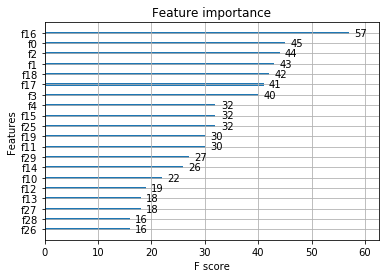

In [553]:
from xgboost import plot_importance

plot_importance(xgb, max_num_features=25)
plt.show()

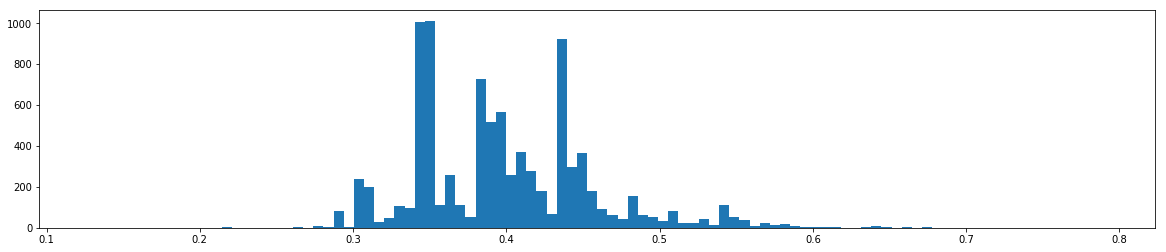

In [554]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [555]:
sub.to_csv('submissions/xgb_baseline_1.csv')

In [557]:
sub.shape

(9112, 1)